<a href="https://colab.research.google.com/github/HitoshiSatoo/treinamento_mult_model_cancer/blob/main/mult_model_cnn_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')
hitoshisato96_modelos_treinado_cancer_path = kagglehub.dataset_download('hitoshisato96/modelos-treinado-cancer')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca637.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3400.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca783.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3927.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca4109.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca95.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca488.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca2140.jp

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 9.3 MB/s 

In [ ]:
!pip install torch torchvision pytorch-lightning timm

In [ ]:
import os

# Caminho onde o Kaggle coloca os datasets importados
dataset_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"

# Listando os arquivos
print("Arquivos no dataset:", os.listdir(dataset_path))

Arquivos no dataset: ['lung_aca', 'lung_scc', 'lung_n']


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os

# ===============================
# 1. Definições e transformações
# ===============================
dataset_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamanho padrão da ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalização do ImageNet
                         std=[0.229, 0.224, 0.225])
])

# ===============================
# 2. Carregamento do dataset
# ===============================
dataset = ImageFolder(root=dataset_path, transform=data_transforms)
print("Total de imagens:", len(dataset))
print("Classes encontradas:", dataset.classes)

# ===============================
# 3. Divisão: Treino, Validação e Teste
# ===============================
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f"Tamanhos -> Treino: {len(train_dataset)}, Validação: {len(val_dataset)}, Teste: {len(test_dataset)}")

# ===============================
# 4. DataLoaders
# ===============================
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Total de imagens: 15000
Classes encontradas: ['lung_aca', 'lung_n', 'lung_scc']
Tamanhos -> Treino: 10500, Validação: 2250, Teste: 2250


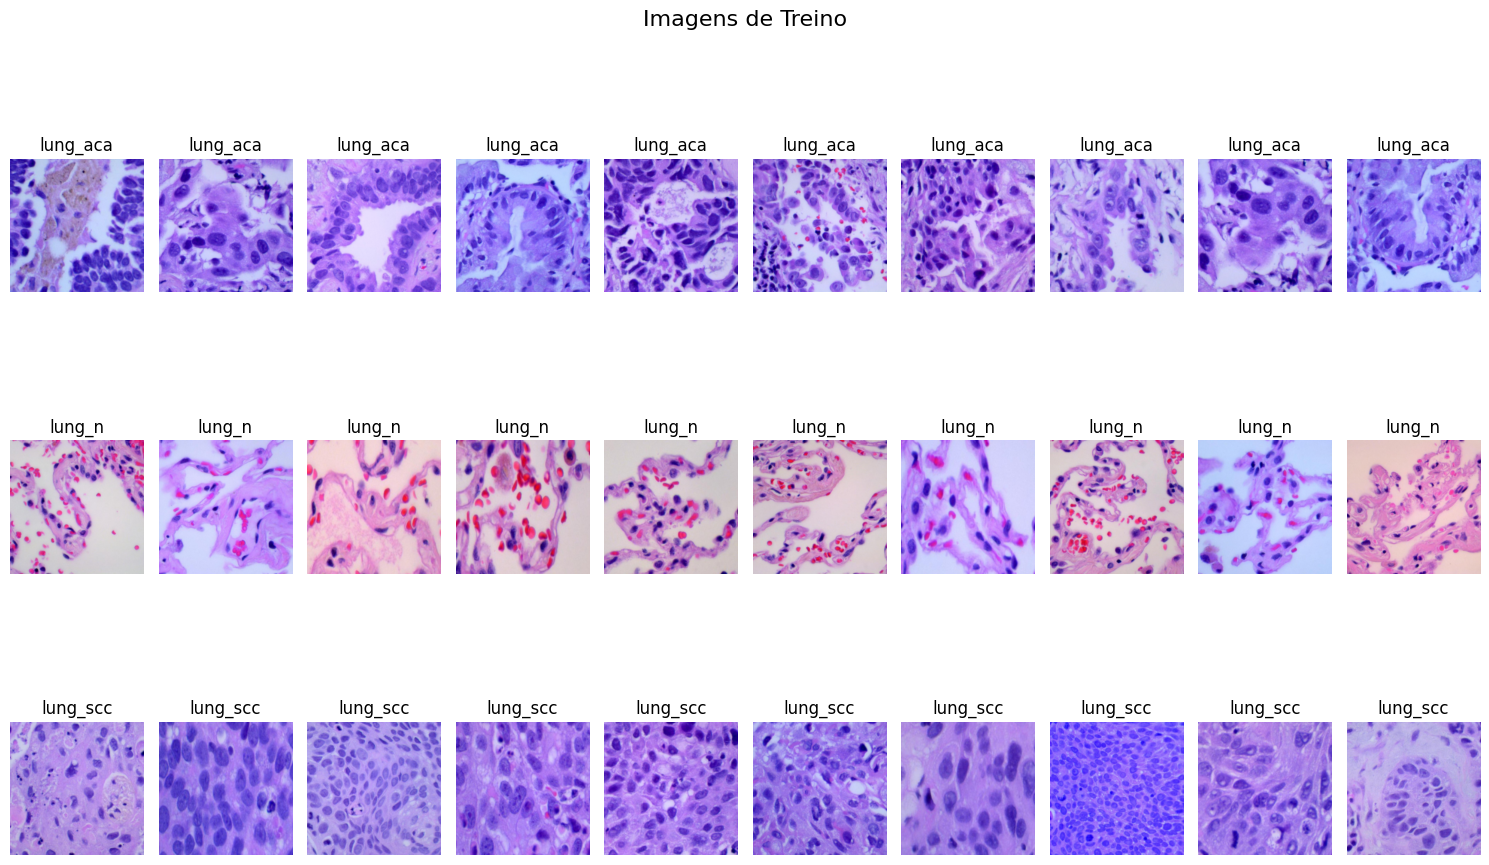

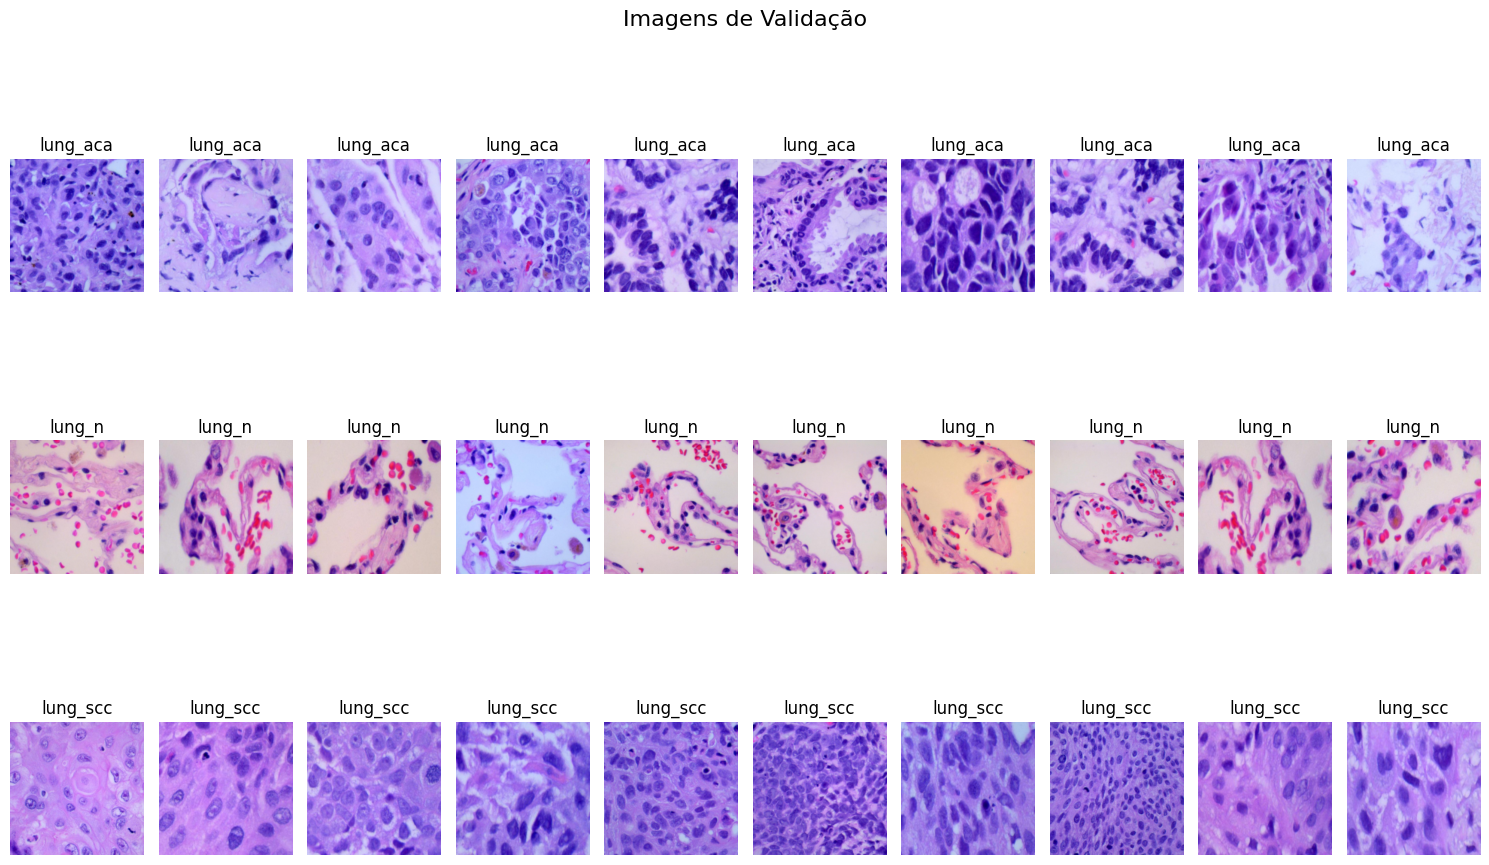

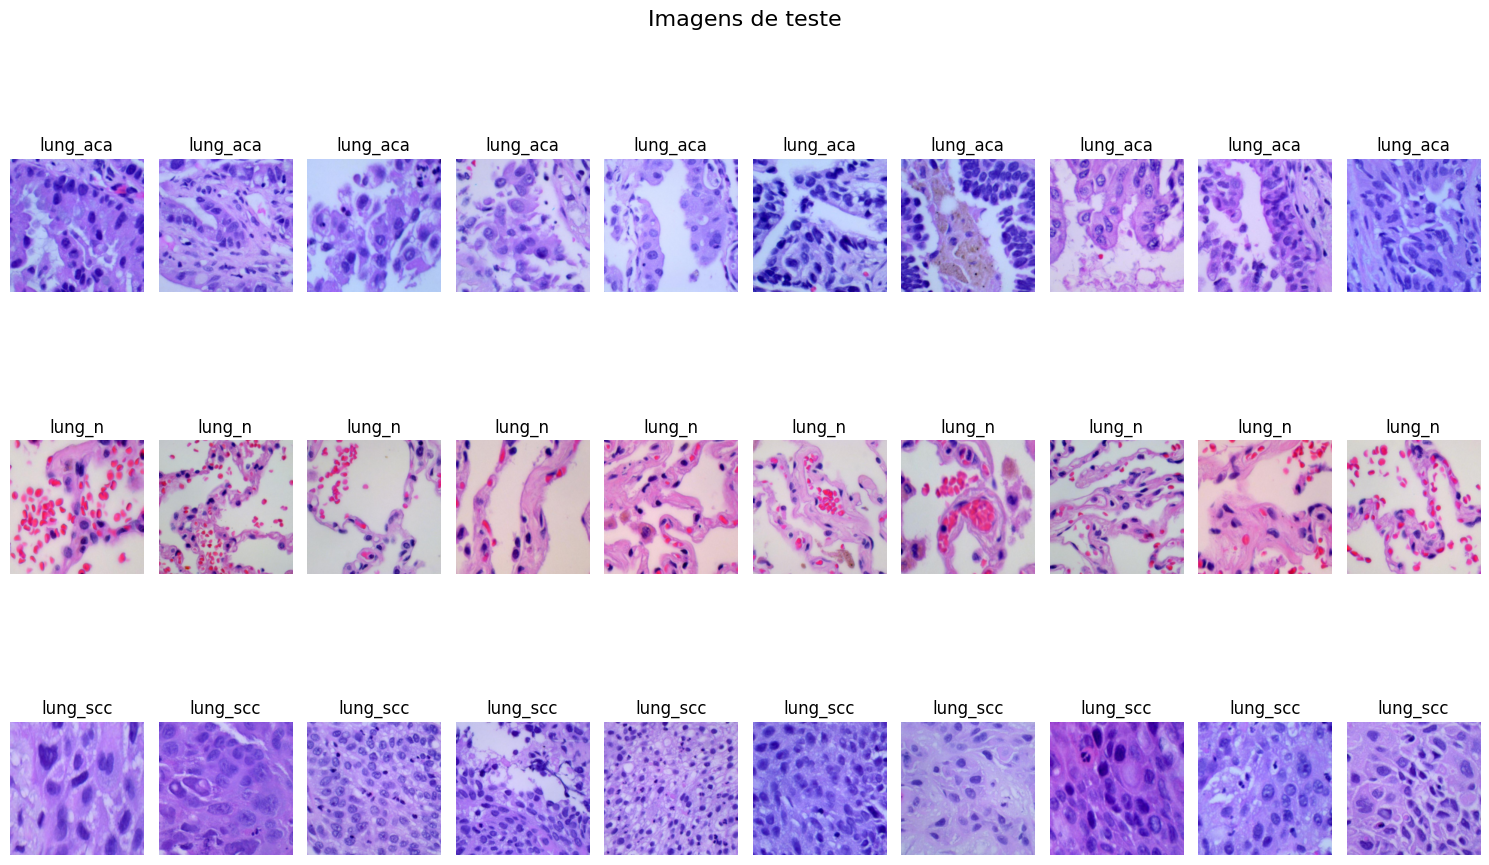

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Função para desnormalizar as imagens (voltar aos valores originais)
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # Médias usadas na normalização
    std = np.array([0.229, 0.224, 0.225])   # Desvios padrão usados na normalização
    img = img.numpy().transpose((1, 2, 0))  # Reorganiza as dimensões do tensor para exibição
    img = img * std + mean  # Reverte a normalização
    img = np.clip(img, 0, 1)  # Garante que os valores fiquem entre 0 e 1
    return img

# Função para exibir imagens do DataLoader
def show_images(dataloader, title, num_images=10):
    class_counts = {class_name: 0 for class_name in dataset.classes}  # Contador de classes
    max_per_class = num_images  # Máximo de imagens por classe

    fig, axes = plt.subplots(len(dataset.classes), num_images, figsize=(15, 10))  # Cria a grade de imagens

    for images, labels in dataloader:
        for img, label in zip(images, labels):
            class_name = dataset.classes[label]  # Nome da classe
            if class_counts[class_name] < max_per_class:
                row = dataset.classes.index(class_name)  # Linha correspondente à classe
                col = class_counts[class_name]  # Próxima coluna disponível
                axes[row, col].imshow(denormalize(img))  # Exibe a imagem desnormalizada
                axes[row, col].axis("off")
                axes[row, col].set_title(class_name)
                class_counts[class_name] += 1

            # Para quando todas as classes atingirem 10 imagens
            if all(count >= max_per_class for count in class_counts.values()):
                break
        if all(count >= max_per_class for count in class_counts.values()):
            break

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Exibir imagens do conjunto de treino
show_images(train_loader, "Imagens de Treino", num_images=10)

# Exibir imagens do conjunto de validação
show_images(val_loader, "Imagens de Validação", num_images=10)
# Exibir imagens do conjunto de validação

show_images(test_loader, "Imagens de teste", num_images=10)


In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision.models as models

class CancerClassifier(pl.LightningModule):
    def __init__(self, model_name='resnet18', num_classes=3, lr=1e-4):
        super(CancerClassifier, self).__init__()
        # Salva os hiperparâmetros (model_name, num_classes, lr)
        # para que fiquem acessíveis via self.hparams
        self.save_hyperparameters()

        # Lógica para selecionar o modelo com base no nome
        if model_name == 'resnet18':
            # Carrega o ResNet18 pré-treinado
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            # A camada final do ResNet se chama 'fc' (fully connected)
            in_features = model.fc.in_features
            model.fc = nn.Linear(in_features, self.hparams.num_classes)

        elif model_name == 'vgg16':
            # Carrega o VGG16 pré-treinado
            model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
            # No VGG, a parte classificadora é um nn.Sequential chamado 'classifier'
            # A última camada linear está no índice 6
            in_features = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(in_features, self.hparams.num_classes)

        elif model_name == 'densenet121':
            # Carrega o DenseNet121 pré-treinado
            model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
            # A camada final do DenseNet se chama 'classifier'
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, self.hparams.num_classes)

        elif model_name == 'efficientnet_b0':
            # Carrega o EfficientNet-B0 pré-treinado
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
            # No EfficientNet, o classificador também é um nn.Sequential
            # A camada linear é a última, no índice 1
            in_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(in_features, self.hparams.num_classes)

        else:
            raise ValueError(f"Modelo '{model_name}' não suportado. Escolha entre: 'resnet18', 'vgg16', 'densenet121', 'efficientnet_b0'")

        self.model = model
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True) # on_epoch=True é bom para acurácia
        return loss

    def configure_optimizers(self):
        # Usa a taxa de aprendizado definida nos hiperparâmetros
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
# Exemplo 1: Treinar com ResNet18
model_resnet = CancerClassifier(model_name='resnet18', num_classes=3, lr=1e-4)

# Exemplo 2: Treinar com VGG16
model_vgg = CancerClassifier(model_name='vgg16', num_classes=3, lr=1e-4)

# Exemplo 3: Treinar com DenseNet121
model_densenet = CancerClassifier(model_name='densenet121', num_classes=3, lr=1e-4)

# Exemplo 4: Treinar com EfficientNet-B0
model_efficientnet = CancerClassifier(model_name='efficientnet_b0', num_classes=3, lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 197MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 208MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s]


In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl

# ===================================================================
# 1. DEFINIÇÃO DO MODELO (A classe flexível que criamos antes)
# ===================================================================
class CancerClassifier(pl.LightningModule):
    def __init__(self, model_name='resnet18', num_classes=3, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        if model_name == 'resnet18':
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            in_features = model.fc.in_features
            model.fc = nn.Linear(in_features, self.hparams.num_classes)
        elif model_name == 'vgg16':
            model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
            in_features = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(in_features, self.hparams.num_classes)
        elif model_name == 'densenet121':
            model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, self.hparams.num_classes)
        elif model_name == 'efficientnet_b0':
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
            in_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(in_features, self.hparams.num_classes)
        else:
            raise ValueError(f"Modelo '{model_name}' não suportado.")

        self.model = model
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    # Adicionando o passo de teste para avaliar o modelo final
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

# ===================================================================
# 2. PREPARAÇÃO DOS DADOS (Seu código, 100% correto)
# ===================================================================
# Definindo o caminho e as transformações
dataset_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregamento e divisão do dataset
# (Garantir reprodutibilidade na divisão adicionando um gerador)
generator = torch.Generator().manual_seed(42)
dataset = ImageFolder(root=dataset_path, transform=data_transforms)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

# DataLoaders
# Nota: o valor de num_workers pode precisar de ajuste dependendo do ambiente (no Kaggle/Colab, 2 é um valor seguro)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("✨ Preparação dos dados concluída!")
print(f"Classes: {dataset.classes}")
print(f"Tamanhos -> Treino: {len(train_dataset)}, Validação: {len(val_dataset)}, Teste: {len(test_dataset)}")

# ===================================================================
# 3. TREINAMENTO DO MODELO
# ===================================================================
# --- Escolha seu modelo aqui ---
CHOSEN_MODEL = 'resnet18'  # Experimente: 'vgg16', 'densenet121', 'efficientnet_b0'
# -----------------------------

# Instancia o modelo
# O número de classes é detectado automaticamente pelo ImageFolder
num_classes = len(dataset.classes)
model = CancerClassifier(model_name=CHOSEN_MODEL, num_classes=num_classes, lr=1e-4)

# Instancia o Trainer
# accelerator='auto' seleciona GPU/TPU se disponível
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='auto',
    # logger=pl.loggers.TensorBoardLogger("logs/", name=CHOSEN_MODEL) # Opcional: para usar TensorBoard
)

# Inicia o treinamento
print(f"\n🚀 Iniciando treinamento com o modelo: {CHOSEN_MODEL}")
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# ===================================================================
# 4. AVALIAÇÃO DO MODELO (no conjunto de teste)
# ===================================================================
print("\n🧪 Avaliando o modelo no conjunto de teste...")
trainer.test(model=model, dataloaders=test_loader)

✨ Preparação dos dados concluída!
Classes: ['lung_aca', 'lung_n', 'lung_scc']
Tamanhos -> Treino: 10500, Validação: 2250, Teste: 2250

🚀 Iniciando treinamento com o modelo: resnet18


2025-08-30 21:03:02.818093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756587783.021201      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756587783.075871      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


🧪 Avaliando o modelo no conjunto de teste...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │  0.00036830679164268076   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.00036830679164268076, 'test_acc': 1.0}]

✨ Preparação dos dados concluída!
Classes: ['lung_aca', 'lung_n', 'lung_scc']
Tamanhos -> Treino: 10500, Validação: 2250, Teste: 2250

🚀 Iniciando treinamento com o modelo: resnet18


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


🧪 Avaliando o melhor modelo no conjunto de teste...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9995555281639099     │
│         test_loss         │   0.0026518641971051693   │
└───────────────────────────┴───────────────────────────┘


📊 Gerando visualizações dos resultados...


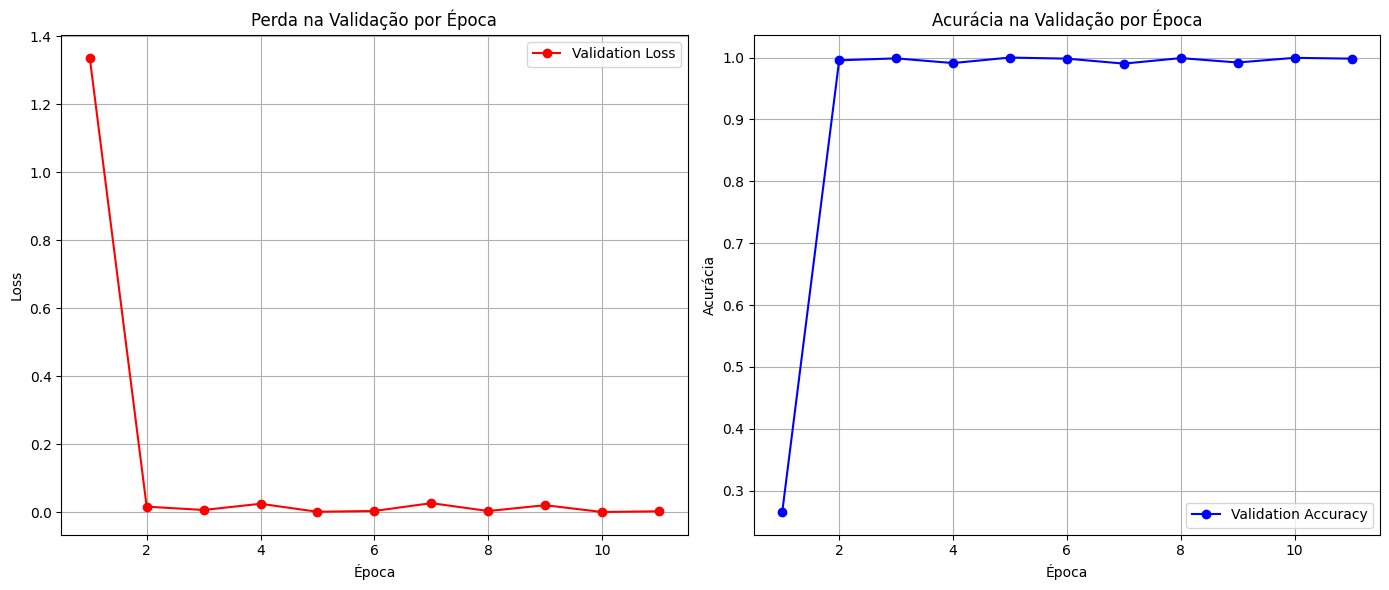

Carregando o melhor modelo de: /kaggle/working/meus_modelos/resnet18-melhor-modelo.ckpt


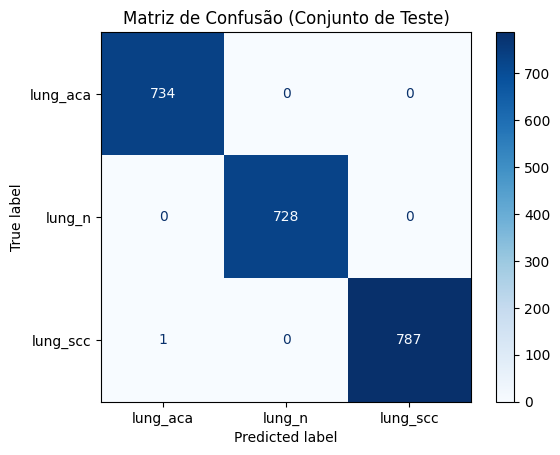


Relatório de Classificação Detalhado (Conjunto de Teste):
              precision    recall  f1-score   support

    lung_aca       1.00      1.00      1.00       734
      lung_n       1.00      1.00      1.00       728
    lung_scc       1.00      1.00      1.00       788

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



In [ ]:
import os
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ===================================================================
# 1. DEFINIÇÃO DO MODELO FLEXÍVEL
# ===================================================================
class CancerClassifier(pl.LightningModule):
    def __init__(self, model_name='resnet18', num_classes=3, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        if model_name == 'resnet18':
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            in_features = model.fc.in_features
            model.fc = nn.Linear(in_features, self.hparams.num_classes)
        elif model_name == 'vgg16':
            model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
            in_features = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(in_features, self.hparams.num_classes)
        elif model_name == 'densenet121':
            model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, self.hparams.num_classes)
        elif model_name == 'efficientnet_b0':
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
            in_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(in_features, self.hparams.num_classes)
        else:
            raise ValueError(f"Modelo '{model_name}' não suportado.")

        self.model = model
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

# ===================================================================
# 2. CALLBACKS E FUNÇÕES DE PLOTAGEM
# ===================================================================

# Callback melhorado: armazena métricas internamente
class MetricsCollector(Callback):
    def __init__(self):
        super().__init__()
        self.val_losses = []
        self.val_accuracies = []

    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get("val_loss")
        val_acc = metrics.get("val_acc")
        if val_loss is not None and val_acc is not None:
            self.val_losses.append(val_loss.item())
            self.val_accuracies.append(val_acc.item())

# Função de plotagem dos resultados do treino
def plot_training_results(metrics_collector):
    epochs = range(1, len(metrics_collector.val_losses) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics_collector.val_losses, 'r-o', label="Validation Loss")
    plt.title("Perda na Validação por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics_collector.val_accuracies, 'b-o', label="Validation Accuracy")
    plt.title("Acurácia na Validação por Época")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Função de plotagem da matriz de confusão e métricas
def plot_confusion_matrix_and_metrics(model, dataloader, class_names):
    # CORREÇÃO: O device é pego diretamente do modelo treinado
    device = model.device
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão (Conjunto de Teste)")
    plt.show()

    print("\nRelatório de Classificação Detalhado (Conjunto de Teste):")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# ===================================================================
# 3. PREPARAÇÃO DOS DADOS
# ===================================================================
dataset_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

generator = torch.Generator().manual_seed(42)
dataset = ImageFolder(root=dataset_path, transform=data_transforms)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)

print("✨ Preparação dos dados concluída!")
print(f"Classes: {dataset.classes}")
print(f"Tamanhos -> Treino: {len(train_dataset)}, Validação: {len(val_dataset)}, Teste: {len(test_dataset)}")

# ===================================================================
# 4. CONFIGURAÇÃO E EXECUÇÃO DO TREINAMENTO
# ===================================================================
# --- Parâmetros Configuráveis ---
CHOSEN_MODEL = 'resnet18'  # Experimente: 'vgg16', 'densenet121', 'efficientnet_b0'
MAX_EPOCHS = 10
LEARNING_RATE = 1e-4
# ---------------------------------

# Callbacks
metrics_collector = MetricsCollector()
checkpoint_callback = ModelCheckpoint(
    dirpath="meus_modelos/",
    filename=f"{CHOSEN_MODEL}-melhor-modelo",
    monitor="val_acc",
    mode="max",
    save_top_k=1 # Salva apenas o melhor modelo
)

# Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="auto", # Seleciona GPU automaticamente se disponível
    devices=1,
    logger=TensorBoardLogger("tb_logs", name=CHOSEN_MODEL),
    callbacks=[checkpoint_callback, metrics_collector]
)

# Instanciação do modelo
model = CancerClassifier(
    model_name=CHOSEN_MODEL,
    num_classes=len(dataset.classes),
    lr=LEARNING_RATE
)

# --- Treinamento ---
print(f"\n🚀 Iniciando treinamento com o modelo: {CHOSEN_MODEL}")
trainer.fit(model, train_loader, val_loader)

# --- Teste (com o melhor modelo encontrado durante o treino) ---
print("\n🧪 Avaliando o melhor modelo no conjunto de teste...")
trainer.test(dataloaders=test_loader, ckpt_path='best') # 'best' carrega o melhor checkpoint automaticamente

# ===================================================================
# 5. ANÁLISE PÓS-TREINAMENTO
# ===================================================================
print("\n📊 Gerando visualizações dos resultados...")

# Plotar gráficos de loss e acurácia
plot_training_results(metrics_collector)

# Carregar o melhor modelo salvo para gerar a matriz de confusão
best_model_path = checkpoint_callback.best_model_path
print(f"Carregando o melhor modelo de: {best_model_path}")
best_model = CancerClassifier.load_from_checkpoint(best_model_path)

# Plotar matriz de confusão e métricas detalhadas
plot_confusion_matrix_and_metrics(best_model, test_loader, class_names=dataset.classes)

✨ Preparação dos dados concluída!
Classes: ['lung_aca', 'lung_n', 'lung_scc']
Tamanhos -> Treino: 10500, Validação: 2250, Teste: 2250


🚀 Iniciando o Treinamento para o Modelo: resnet18


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/meus_modelos exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


🧪 Avaliando o melhor modelo 'resnet18' no conjunto de teste...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.0006730289896950126   │
└───────────────────────────┴───────────────────────────┘


📊 Gerando visualizações para o modelo 'resnet18'...


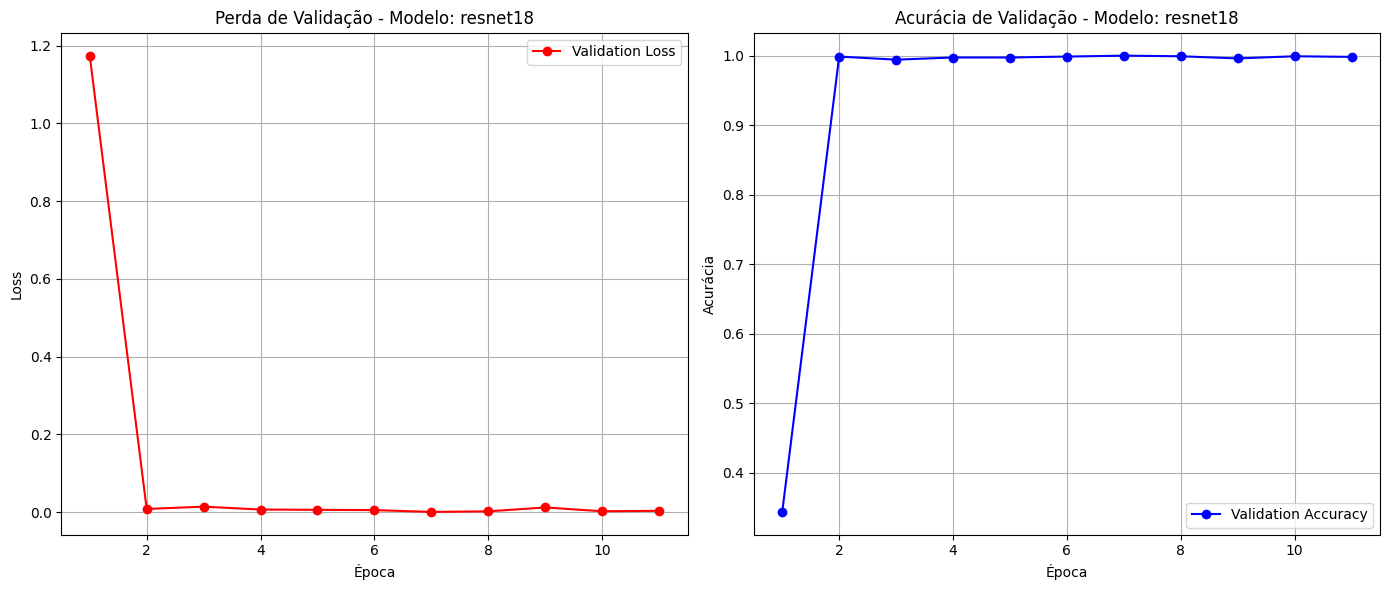

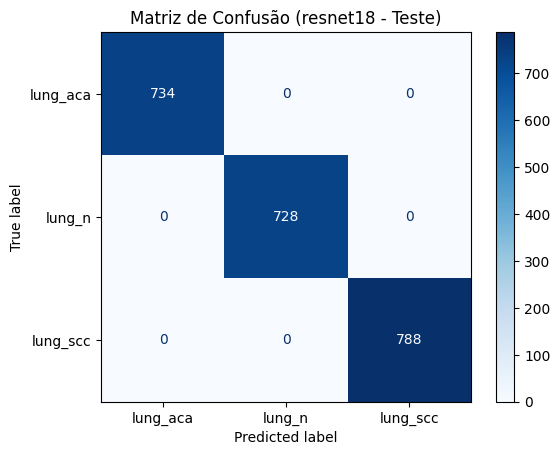


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

    lung_aca       1.00      1.00      1.00       734
      lung_n       1.00      1.00      1.00       728
    lung_scc       1.00      1.00      1.00       788

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



🚀 Iniciando o Treinamento para o Modelo: vgg16


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/meus_modelos exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


🧪 Avaliando o melhor modelo 'vgg16' no conjunto de teste...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.995555579662323     │
│         test_loss         │   0.011737349443137646    │
└───────────────────────────┴───────────────────────────┘


📊 Gerando visualizações para o modelo 'vgg16'...


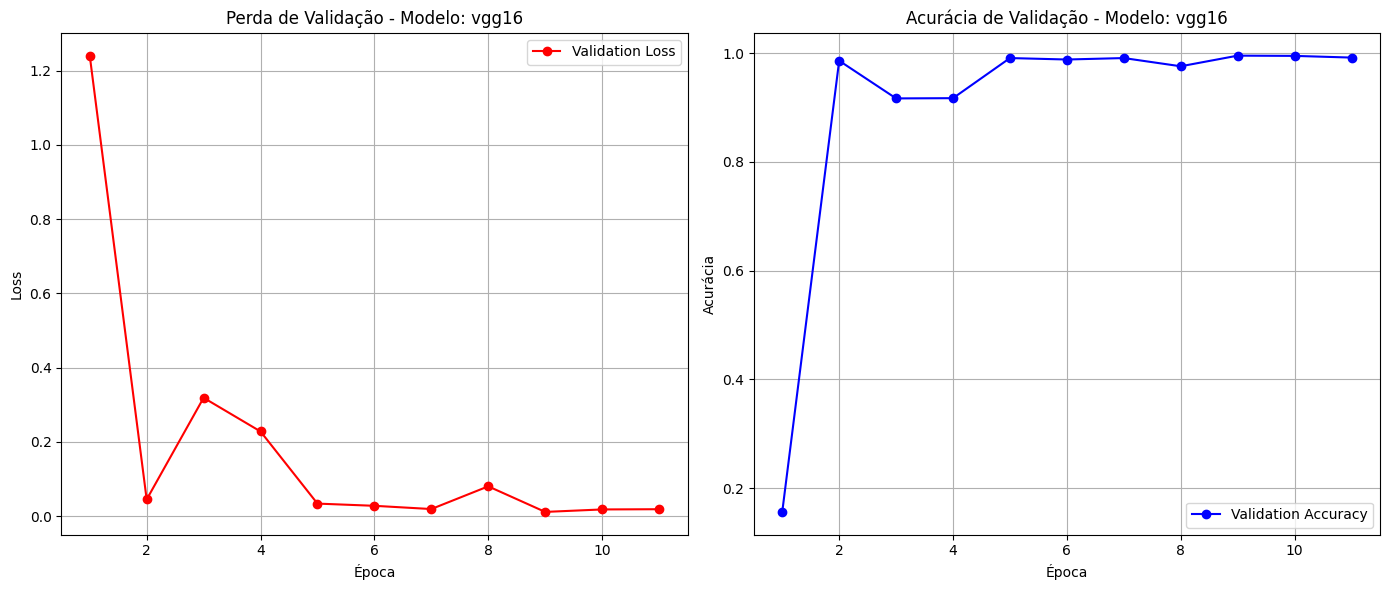

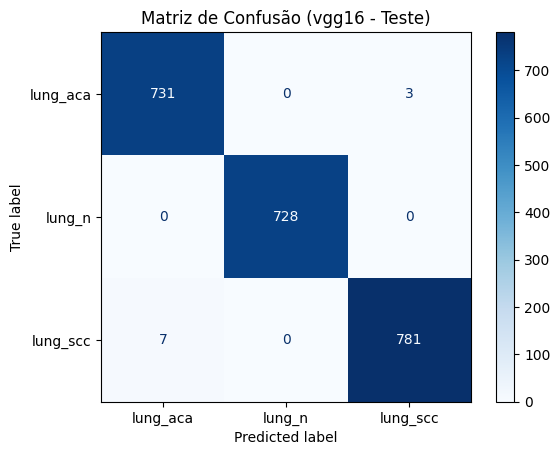


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

    lung_aca       0.99      1.00      0.99       734
      lung_n       1.00      1.00      1.00       728
    lung_scc       1.00      0.99      0.99       788

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



🚀 Iniciando o Treinamento para o Modelo: densenet121


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/meus_modelos exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


🧪 Avaliando o melhor modelo 'densenet121' no conjunto de teste...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.002715203445404768    │
└───────────────────────────┴───────────────────────────┘


📊 Gerando visualizações para o modelo 'densenet121'...


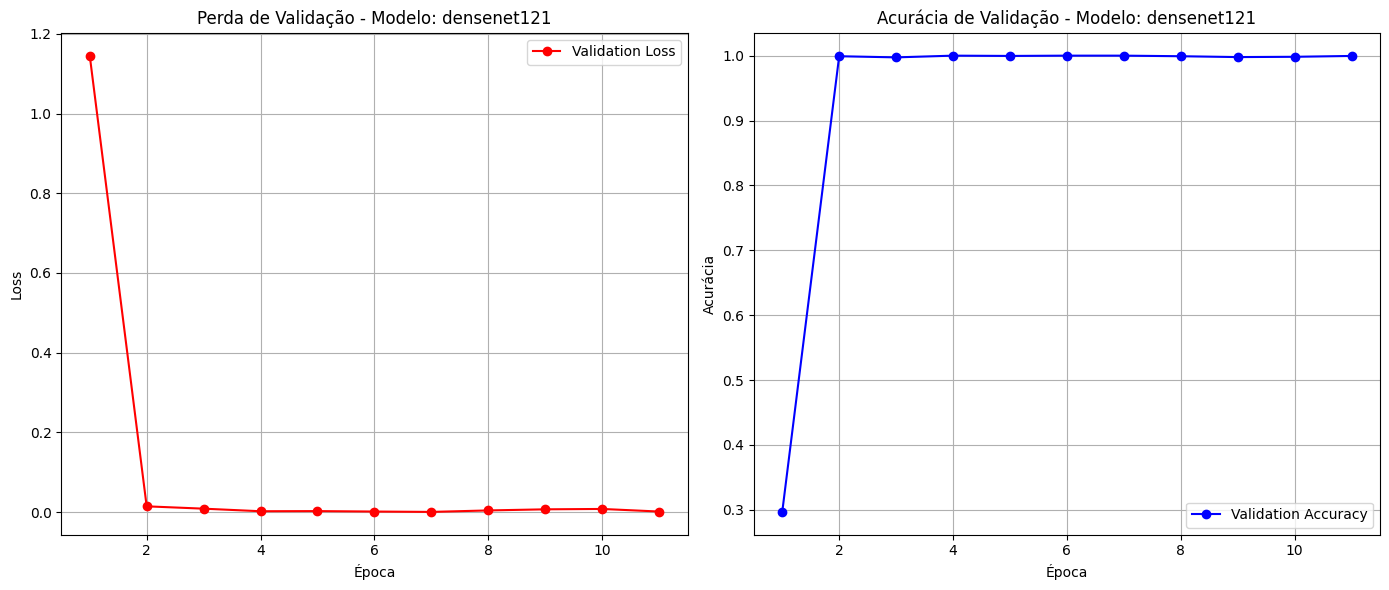

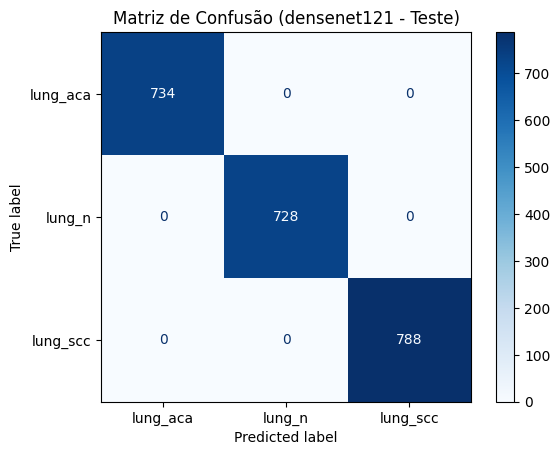


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

    lung_aca       1.00      1.00      1.00       734
      lung_n       1.00      1.00      1.00       728
    lung_scc       1.00      1.00      1.00       788

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



🚀 Iniciando o Treinamento para o Modelo: efficientnet_b0


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/meus_modelos exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


🧪 Avaliando o melhor modelo 'efficientnet_b0' no conjunto de teste...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.0009043046156875789   │
└───────────────────────────┴───────────────────────────┘


📊 Gerando visualizações para o modelo 'efficientnet_b0'...


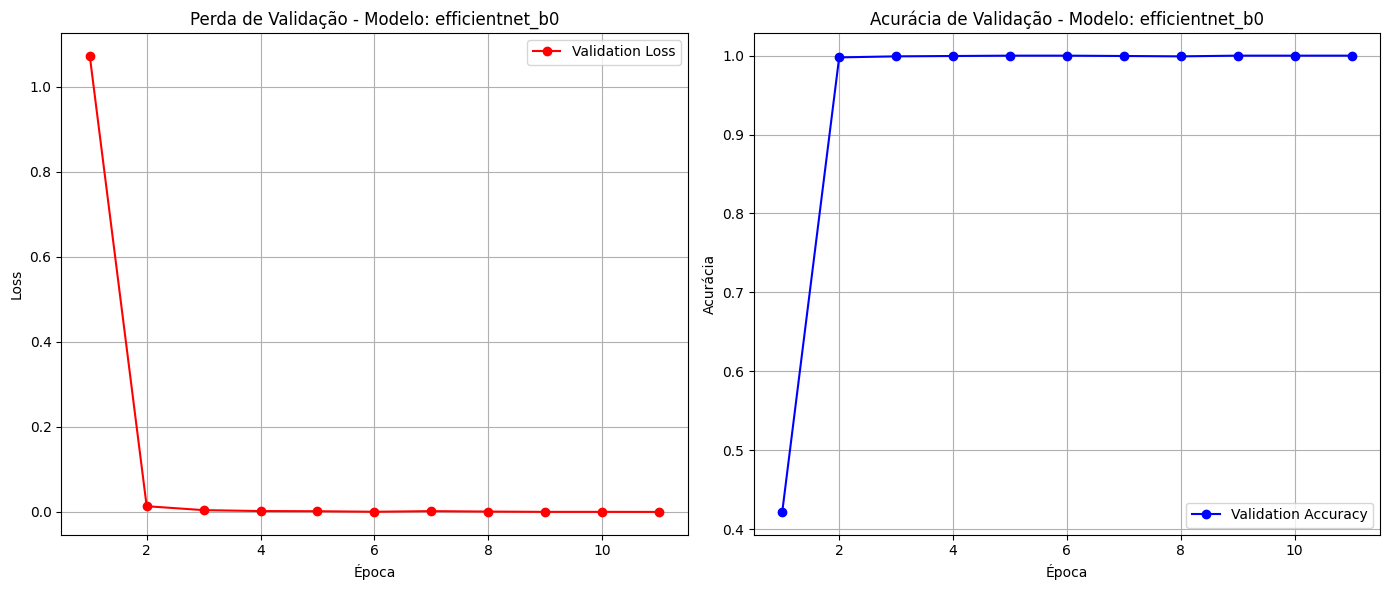

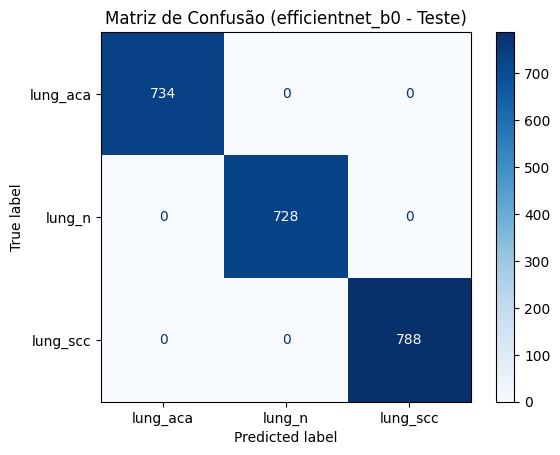


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

    lung_aca       1.00      1.00      1.00       734
      lung_n       1.00      1.00      1.00       728
    lung_scc       1.00      1.00      1.00       788

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250


🎉 Treinamento de todos os modelos concluído!
Os checkpoints estão salvos na pasta 'meus_modelos/'.
Os logs de treinamento para o TensorBoard estão em 'tb_logs/'.


In [ ]:
import os
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ===================================================================
# 1. DEFINIÇÃO DO MODELO FLEXÍVEL (inalterado)
# ===================================================================
class CancerClassifier(pl.LightningModule):
    def __init__(self, model_name='resnet18', num_classes=3, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        if model_name == 'resnet18':
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            in_features = model.fc.in_features
            model.fc = nn.Linear(in_features, self.hparams.num_classes)
        elif model_name == 'vgg16':
            model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
            in_features = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(in_features, self.hparams.num_classes)
        elif model_name == 'densenet121':
            model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, self.hparams.num_classes)
        elif model_name == 'efficientnet_b0':
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
            in_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(in_features, self.hparams.num_classes)
        else:
            raise ValueError(f"Modelo '{model_name}' não suportado.")
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss)
        return loss
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

# ===================================================================
# 2. FUNÇÕES DE PLOTAGEM E CALLBACK (inalterado)
# ===================================================================
class MetricsCollector(Callback):
    def __init__(self):
        super().__init__()
        self.val_losses = []
        self.val_accuracies = []
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get("val_loss")
        val_acc = metrics.get("val_acc")
        if val_loss is not None and val_acc is not None:
            self.val_losses.append(val_loss.item())
            self.val_accuracies.append(val_acc.item())

def plot_training_results(metrics_collector, model_name):
    epochs = range(1, len(metrics_collector.val_losses) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics_collector.val_losses, 'r-o', label="Validation Loss")
    plt.title(f"Perda de Validação - Modelo: {model_name}")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics_collector.val_accuracies, 'b-o', label="Validation Accuracy")
    plt.title(f"Acurácia de Validação - Modelo: {model_name}")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_and_metrics(model, dataloader, class_names, model_name):
    device = model.device
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusão ({model_name} - Teste)")
    plt.show()
    print("\nRelatório de Classificação Detalhado:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# ===================================================================
# 3. PREPARAÇÃO DOS DADOS (executado uma única vez)
# ===================================================================
dataset_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
generator = torch.Generator().manual_seed(42)
dataset = ImageFolder(root=dataset_path, transform=data_transforms)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)
class_names = dataset.classes

print("✨ Preparação dos dados concluída!")
print(f"Classes: {class_names}")
print(f"Tamanhos -> Treino: {len(train_dataset)}, Validação: {len(val_dataset)}, Teste: {len(test_dataset)}")

# ===================================================================
# 4. LOOP PRINCIPAL PARA TREINAR TODOS OS MODELOS
# ===================================================================

MODELS_TO_TRAIN = ['resnet18', 'vgg16', 'densenet121', 'efficientnet_b0']
MAX_EPOCHS = 10
LEARNING_RATE = 1e-4

for model_name in MODELS_TO_TRAIN:
    print(f"\n\n=======================================================")
    print(f"🚀 Iniciando o Treinamento para o Modelo: {model_name}")
    print(f"=======================================================")

    # Instancia o modelo, logger e callbacks dentro do loop
    model = CancerClassifier(
        model_name=model_name,
        num_classes=len(class_names),
        lr=LEARNING_RATE
    )
    metrics_collector = MetricsCollector()
    logger = TensorBoardLogger("tb_logs", name=model_name)
    checkpoint_callback = ModelCheckpoint(
        dirpath="meus_modelos/",
        filename=f"{model_name}-melhor-modelo",
        monitor="val_acc",
        mode="max",
        save_top_k=1
    )

    # Configura e inicia o treinamento
    trainer = pl.Trainer(
        max_epochs=MAX_EPOCHS,
        accelerator="auto",
        devices=1,
        logger=logger,
        callbacks=[checkpoint_callback, metrics_collector]
    )
    trainer.fit(model, train_loader, val_loader)

    # Avalia o melhor modelo salvo no conjunto de teste
    print(f"\n🧪 Avaliando o melhor modelo '{model_name}' no conjunto de teste...")
    trainer.test(dataloaders=test_loader, ckpt_path='best')

    # Análise Pós-Treinamento
    print(f"\n📊 Gerando visualizações para o modelo '{model_name}'...")
    plot_training_results(metrics_collector, model_name)

    # Carrega o melhor modelo salvo para a matriz de confusão
    best_model = CancerClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)
    plot_confusion_matrix_and_metrics(best_model, test_loader, class_names, model_name)

print("\n🎉 Treinamento de todos os modelos concluído!")
print("Os checkpoints estão salvos na pasta 'meus_modelos/'.")
print("Os logs de treinamento para o TensorBoard estão em 'tb_logs/'.")